In [21]:
import torch
import numpy as np
import torch.utils
import matplotlib.pyplot as plt
import numpy as np
import utils.visualize

In [22]:
import importlib
importlib.reload(utils.visualize)

<module 'utils.visualize' from '/notebooks/utils/visualize.py'>

In [2]:
def visualize_reconstructed_imgs(model, dataloader, num_imgs, device):
    # Visualize reconstructions only
    model.eval()
    with torch.no_grad():
        test_data, _ = next(iter(dataloader))
        test_data = test_data.to(device)
        model_output = model(test_data)
        reconstructions = model_output['reconstructions']

        # Adjust figure size dynamically
        plt.figure(figsize=(num_imgs * 2, 4)) 
        for i in range(num_imgs):
            # Original image
            plt.subplot(2, num_imgs, i+1)
            plt.imshow(test_data[i].cpu().permute(1, 2, 0).numpy())
            plt.axis('off')
            if i == 0:
                plt.title('Original')
            # Reconstructed image
            plt.subplot(2, num_imgs, i+1+num_imgs)
            if reconstructions.shape[1] == 1: # Handle grayscale
                plt.imshow(reconstructions[i].cpu().squeeze().numpy(), cmap='gray')
            else: # Handle RGB
                plt.imshow(reconstructions[i].cpu().permute(1, 2, 0).numpy())
            plt.axis('off')
            if i == 0:
                plt.title('Reconstructed')
        plt.tight_layout()
        plt.show()

In [3]:
def visualize_generated_imgs(model, num_imgs, device):
    model.eval()
    latent_dim = getattr(model, 'latent_dim', 10)  # get latent_dim from model, default to 10
    with torch.no_grad():
        # Sample latent vectors
        z = torch.randn(num_imgs, latent_dim).to(device)
        # Generate images
        reconstructions = model.decoder(z)['reconstructions']
        
        # Calculate grid size
        n_cols = int(np.ceil(np.sqrt(num_imgs)))
        n_rows = int(np.ceil(num_imgs / n_cols))
        
        # Adjust figure size dynamically
        plt.figure(figsize=(n_cols * 2, n_rows * 2))
        for i in range(num_imgs):
            plt.subplot(n_rows, n_cols, i+1)
            if reconstructions.shape[1] == 1: # Handle grayscale
                plt.imshow(reconstructions[i].cpu().squeeze().numpy(), cmap='gray')
            else: # Handle RGB
                plt.imshow(reconstructions[i].cpu().permute(1, 2, 0).numpy())
            plt.axis('off')
        plt.tight_layout()
        plt.show()

In [4]:
def train_model(model, dataloader, optimizer, loss_fn, num_epochs, device):
    train_losses = []
    for epoch in range(num_epochs):
        epoch_loss = 0
        total_rec_loss = 0
        total_kl_loss = 0
        for batch_idx, (data, _) in enumerate(dataloader):
            data = data.to(device)
            optimizer.zero_grad()
            model_output = model(data)
            reconstructions = model_output['reconstructions']
            stats_qzx = model_output['stats_qzx']
            
            loss_output = loss_fn(data, reconstructions, stats_qzx, is_train=True)
            loss = loss_output['loss']
            total_rec_loss += loss_output['to_log']['rec_loss']
            total_kl_loss += loss_output['to_log']['kl_loss']
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_epoch_loss = epoch_loss / len(dataloader)
        avg_rec_loss = total_rec_loss / len(dataloader)
        avg_kl_loss = total_kl_loss / len(dataloader)
        train_losses.append(avg_epoch_loss)
        print(f'Epoch: {epoch+1}/{num_epochs}, Average Loss: {avg_epoch_loss:.4f}, Reconstruction: {avg_rec_loss:.4f}, KL: {avg_kl_loss:.4f}')

# Load datasets

In [5]:
from utils.io import find_optimal_num_workers
from datasets import get_dataset, get_dataloaders
import matplotlib.pyplot as plt

In [6]:
batch_size = 64

## 3D Shapes

In [7]:
Shapes3D = get_dataset("shapes3d")
shapes3d = Shapes3D(selected_factors='all', not_selected_factors_index_value=None)

In [8]:
num_workers = find_optimal_num_workers(shapes3d, batch_size=batch_size)
shapes3d_dataloader = torch.utils.data.DataLoader(shapes3d, batch_size=batch_size, num_workers=num_workers, shuffle=True, pin_memory=True)

Defaulting max_workers to physical core count: 8
Finding optimal num_workers (testing 0 to 8)...
  num_workers=0: Warming up with 5 batches...
  num_workers=0: 0.00308 sec/batch
  num_workers=1: Warming up with 5 batches...
  num_workers=1: 0.00514 sec/batch
  num_workers=2: Warming up with 5 batches...
  num_workers=2: 0.00280 sec/batch
  num_workers=3: Warming up with 5 batches...
  num_workers=3: 0.00292 sec/batch
  num_workers=4: Warming up with 5 batches...
  num_workers=4: 0.00278 sec/batch
  num_workers=5: Warming up with 5 batches...
  num_workers=5: 0.00253 sec/batch
  num_workers=6: Warming up with 5 batches...
  num_workers=6: 0.00274 sec/batch
  num_workers=7: Warming up with 5 batches...
  num_workers=7: 0.00244 sec/batch
  num_workers=8: Warming up with 5 batches...
  num_workers=8: 0.00426 sec/batch
Optimal num_workers: 7 (0.00244 sec/batch)


## DSprites

In [9]:
Dsprites = get_dataset('dsprites')
dsprites = Dsprites(selected_factors='all', not_selected_factors_index_value=None)

In [10]:
num_workers = find_optimal_num_workers(dsprites, batch_size=batch_size)
dsprites_dataloader = torch.utils.data.DataLoader(
    dsprites, 
    batch_size=batch_size, 
    num_workers=4, 
    shuffle=True, 
    pin_memory=True
)

Defaulting max_workers to physical core count: 8
Finding optimal num_workers (testing 0 to 8)...
  num_workers=0: Warming up with 5 batches...
  num_workers=0: 0.00984 sec/batch
  num_workers=1: Warming up with 5 batches...
  num_workers=1: 0.00406 sec/batch
  num_workers=2: Warming up with 5 batches...
  num_workers=2: 0.00225 sec/batch
  num_workers=3: Warming up with 5 batches...
  num_workers=3: 0.00184 sec/batch
  num_workers=4: Warming up with 5 batches...
  num_workers=4: 0.00178 sec/batch
  num_workers=5: Warming up with 5 batches...
  num_workers=5: 0.00166 sec/batch
  num_workers=6: Warming up with 5 batches...
  num_workers=6: 0.00147 sec/batch
  num_workers=7: Warming up with 5 batches...
  num_workers=7: 0.00151 sec/batch
  num_workers=8: Warming up with 5 batches...
  num_workers=8: 0.00194 sec/batch
Optimal num_workers: 6 (0.00147 sec/batch)


# Beta VAE

In [11]:
from models.vae_burgess import Model
from losses.betavae import Loss
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 3dShapes

In [12]:
# Create Beta VAE model for 3D Shapes
img_size = shapes3d[0][0].shape
latent_dim = 10
beta = 10

# Initialize the model and loss function
model_3dshapes = Model(img_size=img_size, latent_dim=latent_dim).to(device)
loss_fn_3dshapes = Loss(beta=beta, rec_dist='gaussian')
optimizer_3dshapes = optim.Adam(model_3dshapes.parameters(), lr=1e-4)

# Set up training parameters
num_epochs = 5

In [13]:
# Training loop for the Beta VAE on 3dShapes dataset using the generic function
train_losses = train_model(model_3dshapes, shapes3d_dataloader, optimizer_3dshapes, loss_fn_3dshapes, num_epochs, device)

Epoch: 1/5, Average Loss: 443.2610, Reconstruction: 337.8732, KL: 10.5388
Epoch: 2/5, Average Loss: 272.4408, Reconstruction: 152.5066, KL: 11.9934
Epoch: 3/5, Average Loss: 247.4767, Reconstruction: 123.7880, KL: 12.3689
Epoch: 4/5, Average Loss: 234.4815, Reconstruction: 110.1653, KL: 12.4316
Epoch: 5/5, Average Loss: 226.2431, Reconstruction: 101.8146, KL: 12.4428


In [14]:
# Visualize training results using the generic function
# visualize_reconstructed_imgs(model_3dshapes, shapes3d_dataloader, 10, device)
# visualize_generated_imgs(model_3dshapes, 10, device)

In [23]:
visualizer = utils.visualize.Visualizer(vae_model=model_3dshapes, dataset=shapes3d)

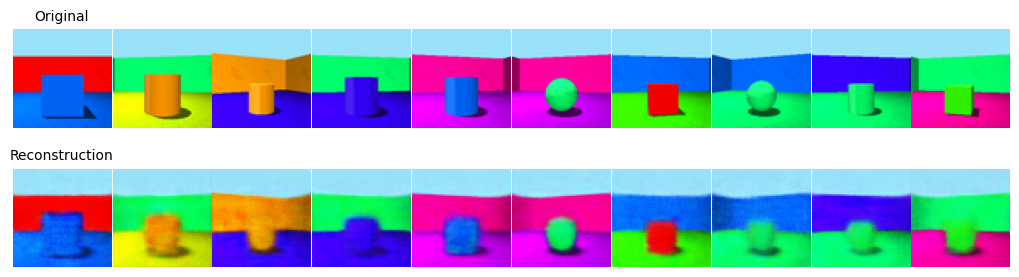

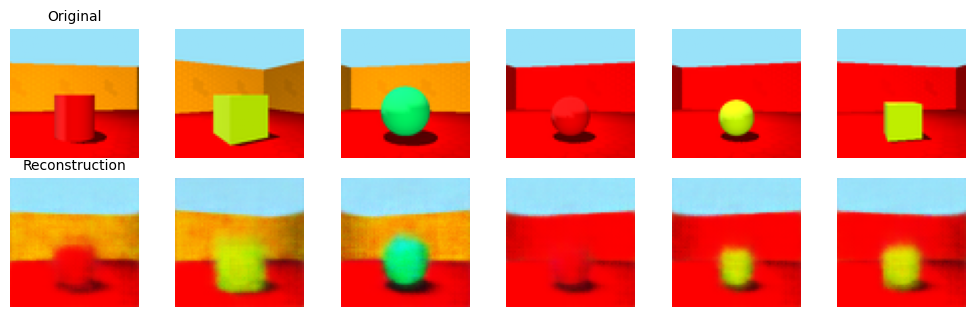

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

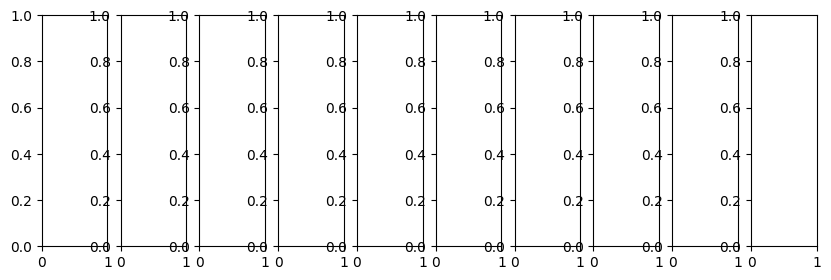

In [24]:
visualizer.plot_random_reconstructions(10, mode='mean')
visualizer.plot_reconstructions_sub_dataset([5000, 6000, 7000, 100, 1000, 1024], mode='mean')
visualizer.plot_single_latent_traversal(0,10)

## dSprites

In [17]:
# Create Beta VAE model for dSprites
img_size = dsprites[0][0].shape
latent_dim = 10
beta = 4.0  # Standard value for disentanglement in Beta-VAE

# Initialize the model and loss function
model_dsprites = Model(img_size=img_size, latent_dim=latent_dim).to(device)
loss_fn_dsprites = Loss(beta=beta, rec_dist='gaussian')
optimizer_dsprites = optim.Adam(model_dsprites.parameters(), lr=1e-4)

# Set up training parameters
num_epochs = 5

In [18]:
train_model(model_dsprites, dsprites_dataloader, optimizer_dsprites, loss_fn_dsprites, num_epochs, device)

Epoch: 1/10, Average Loss: 83.4932, Reconstruction: 58.4649, KL: 6.2571
Epoch: 2/10, Average Loss: 67.7138, Reconstruction: 40.8674, KL: 6.7116
Epoch: 3/10, Average Loss: 66.0482, Reconstruction: 38.7798, KL: 6.8171
Epoch: 4/10, Average Loss: 65.2222, Reconstruction: 37.5135, KL: 6.9272
Epoch: 5/10, Average Loss: 64.8183, Reconstruction: 36.9585, KL: 6.9649
Epoch: 6/10, Average Loss: 64.5409, Reconstruction: 36.6164, KL: 6.9811
Epoch: 7/10, Average Loss: 64.3847, Reconstruction: 36.3904, KL: 6.9986
Epoch: 8/10, Average Loss: 64.2467, Reconstruction: 36.2143, KL: 7.0081
Epoch: 9/10, Average Loss: 64.1416, Reconstruction: 36.0605, KL: 7.0203
Epoch: 10/10, Average Loss: 64.0584, Reconstruction: 35.9349, KL: 7.0309


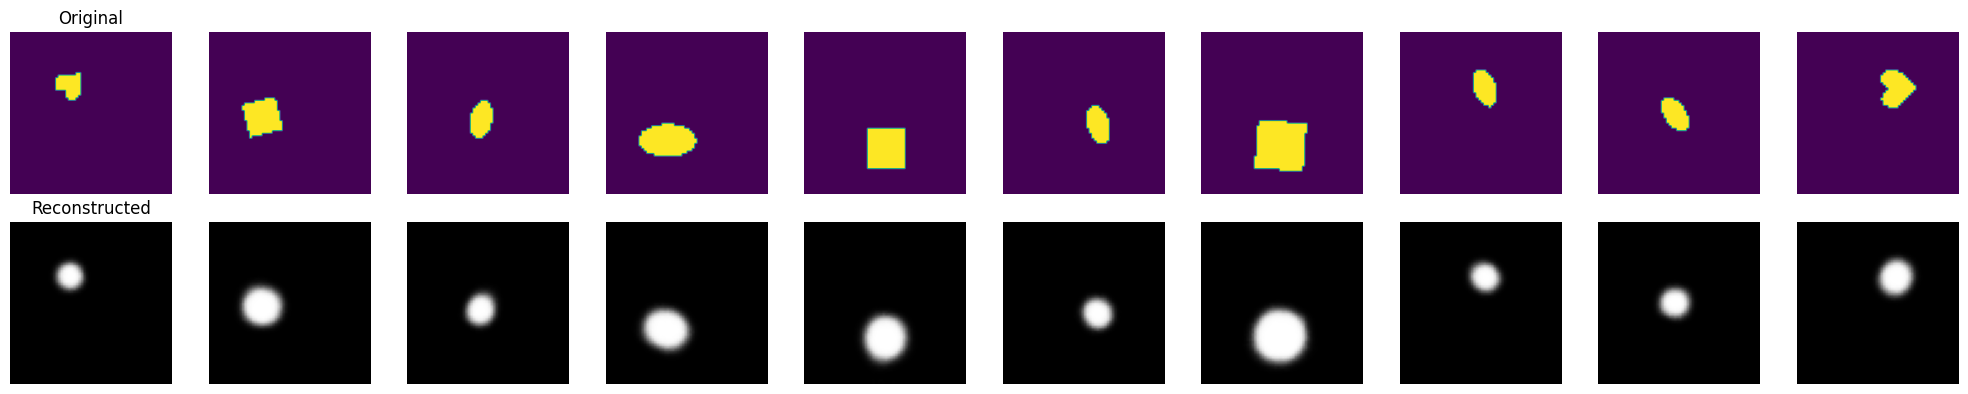

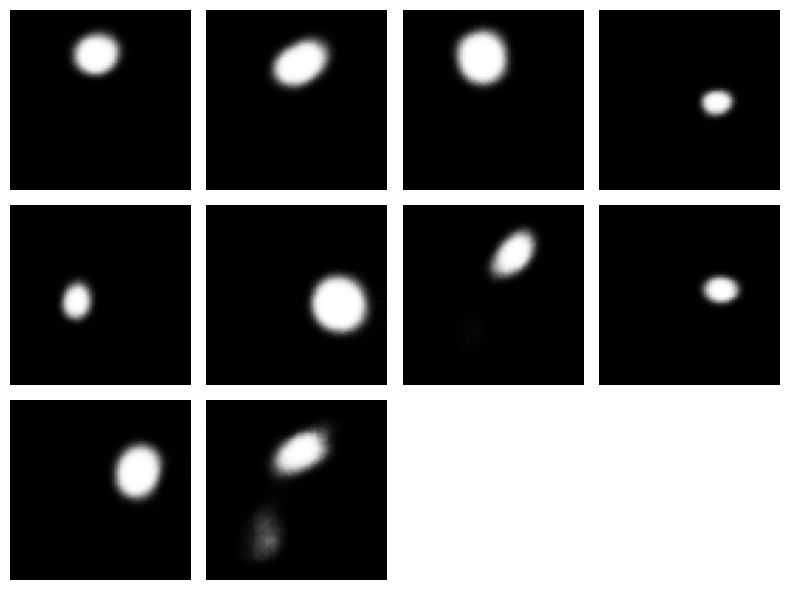

In [19]:
visualize_reconstructed_imgs(model_dsprites, dsprites_dataloader, 10, device)
visualize_generated_imgs(model_dsprites, 10, device)

# Annealed VAE

In [30]:
from models.vae_burgess import Model
from losses.annealedvae import Loss as AnnealedLoss
import torch.optim as optim

## 3dShapes

In [31]:
# Create Annealed VAE model for 3D Shapes
img_size = shapes3d[0][0].shape
latent_dim = 10

# Initialize the model and loss function with annealing parameters
model_annealed_3dshapes = Model(img_size=img_size, latent_dim=latent_dim).to(device)
loss_fn_annealed_3dshapes = AnnealedLoss(
    C_init=0.0,          # Starting capacity
    C_fin=25.0,          # Final capacity
    gamma=100.0,         # Weight of KL divergence term
    anneal_steps=10000,  # Steps over which to anneal the capacity
    rec_dist='gaussian'  # Reconstruction distribution
)
optimizer_annealed_3dshapes = optim.Adam(model_annealed_3dshapes.parameters(), lr=1e-4)

# Set up training parameters
num_epochs = 5

In [32]:
# Training loop for the Annealed VAE on 3dShapes dataset
train_model(model_annealed_3dshapes, shapes3d_dataloader, optimizer_annealed_3dshapes, loss_fn_annealed_3dshapes, num_epochs, device)

Epoch: 1/5, Average Loss: 524.7945, Reconstruction: 506.8087, KL: 9.4110
Epoch: 2/5, Average Loss: 182.9840, Reconstruction: 154.5538, KL: 23.9587
Epoch: 3/5, Average Loss: 119.6861, Reconstruction: 93.7384, KL: 25.0020
Epoch: 4/5, Average Loss: 100.2475, Reconstruction: 76.4575, KL: 25.0040
Epoch: 5/5, Average Loss: 88.2677, Reconstruction: 66.9927, KL: 25.0013


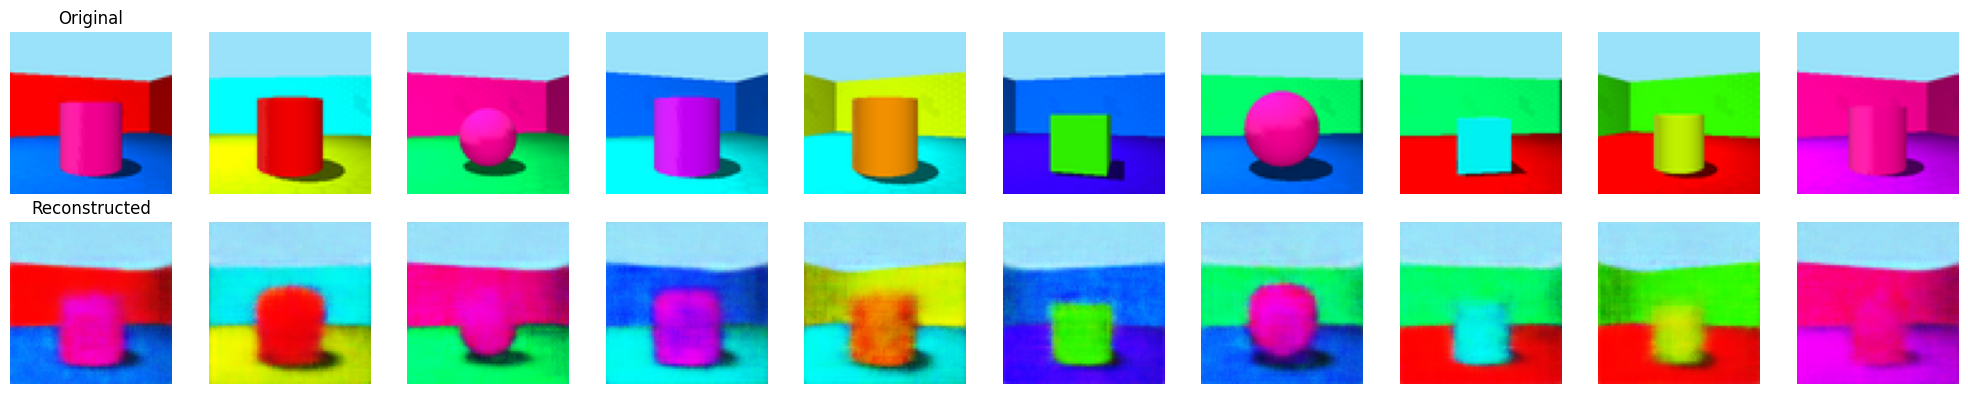

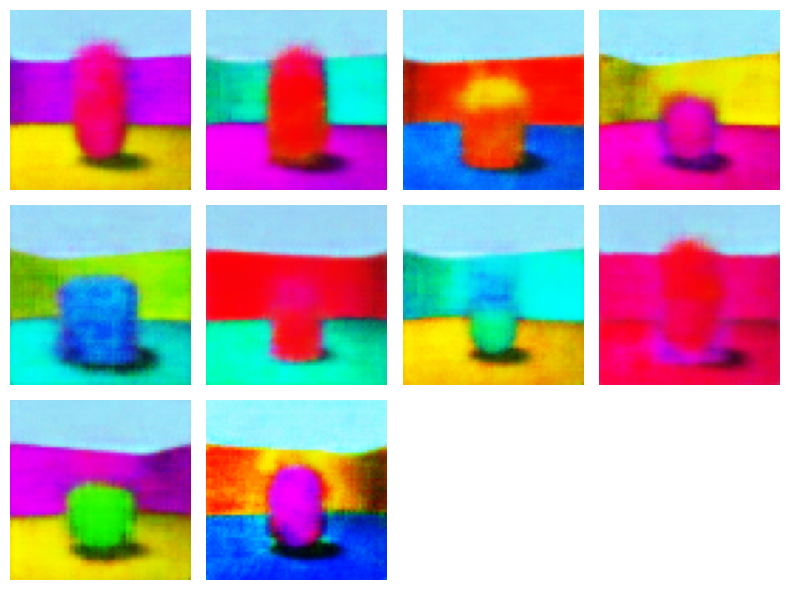

In [33]:
# Visualize training results
visualize_reconstructed_imgs(model_annealed_3dshapes, shapes3d_dataloader, 10, device)
visualize_generated_imgs(model_annealed_3dshapes, 10, device)

## dSprites

In [34]:
# Create Annealed VAE model for dSprites
img_size = dsprites[0][0].shape
latent_dim = 10

# Initialize the model and loss function with annealing parameters
model_annealed_dsprites = Model(img_size=img_size, latent_dim=latent_dim).to(device)
loss_fn_annealed_dsprites = AnnealedLoss(
    C_init=0.0,          # Starting capacity
    C_fin=15.0,          # Final capacity for dSprites (usually lower than 3dShapes)
    gamma=100.0,         # Weight of KL divergence term
    anneal_steps=10000,  # Steps over which to anneal the capacity
    rec_dist='gaussian'  # Reconstruction distribution
)
optimizer_annealed_dsprites = optim.Adam(model_annealed_dsprites.parameters(), lr=1e-4)

# Set up training parameters
num_epochs = 5

In [35]:
# Training loop for the Annealed VAE on dSprites dataset
train_model(model_annealed_dsprites, dsprites_dataloader, optimizer_annealed_dsprites, loss_fn_annealed_dsprites, num_epochs, device)

Epoch: 1/5, Average Loss: 117.7032, Reconstruction: 103.5409, KL: 8.4902
Epoch: 2/5, Average Loss: 44.7009, Reconstruction: 33.6293, KL: 14.9993
Epoch: 3/5, Average Loss: 41.3783, Reconstruction: 31.9772, KL: 14.9998
Epoch: 4/5, Average Loss: 38.0191, Reconstruction: 29.3839, KL: 15.0006
Epoch: 5/5, Average Loss: 36.1048, Reconstruction: 28.2405, KL: 15.0002


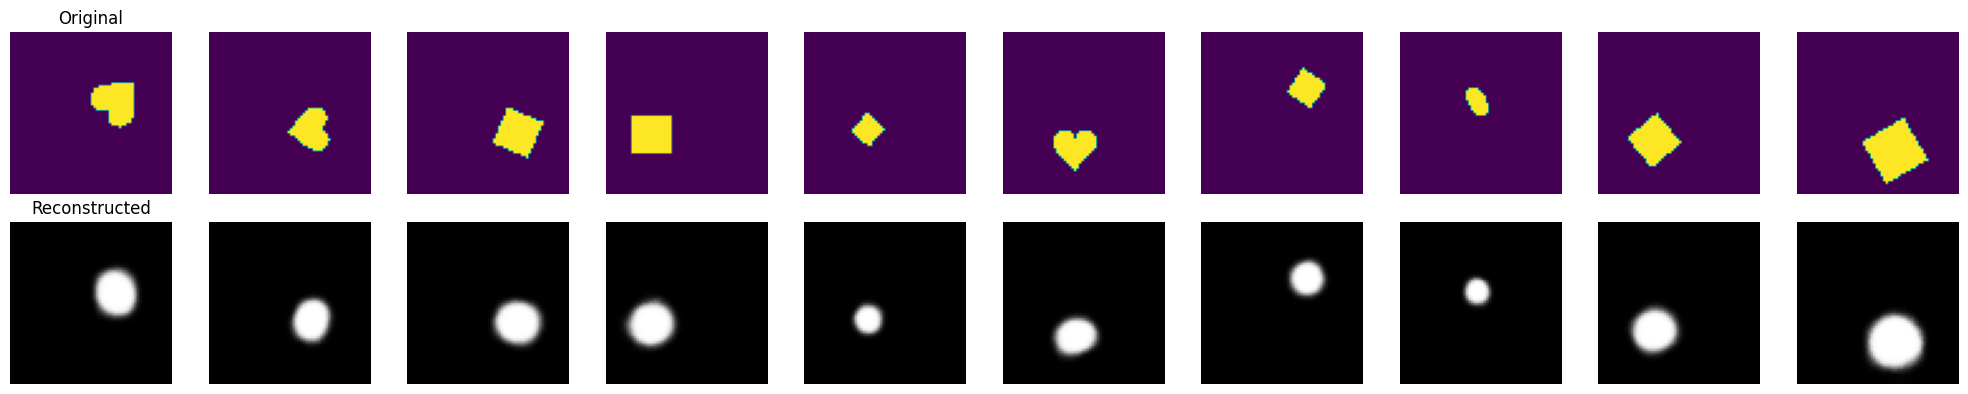

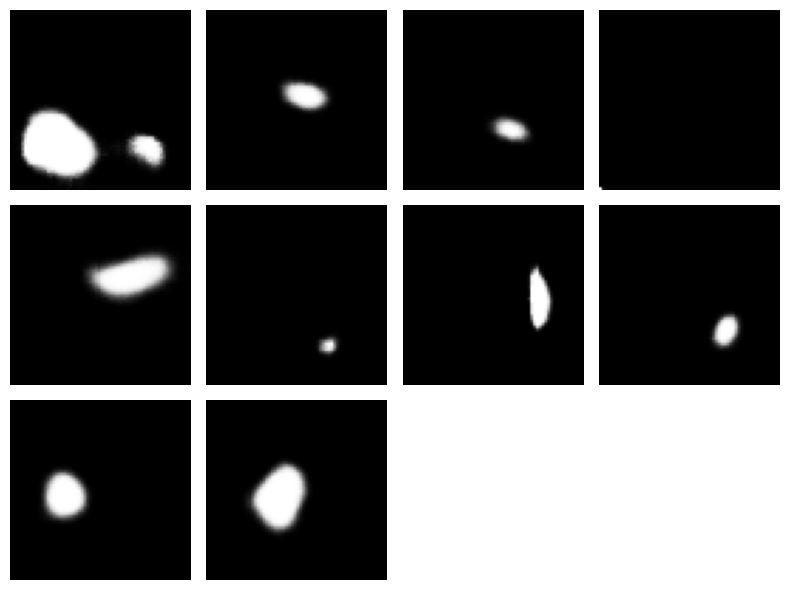

In [36]:
# Visualize training results
visualize_reconstructed_imgs(model_annealed_dsprites, dsprites_dataloader, 10, device)
visualize_generated_imgs(model_annealed_dsprites, 10, device)

# Beta-TC VAE

In [37]:
from models.vae_burgess import Model
from losses.betatcvae import Loss as BetaTCLoss
import torch.optim as optim

## 3dShapes

In [38]:
# Create Beta-TC VAE model for 3D Shapes
img_size = shapes3d[0][0].shape
latent_dim = 10

# Initialize the model and loss function with Beta-TC parameters
model_betatc_3dshapes = Model(img_size=img_size, latent_dim=latent_dim).to(device)
loss_fn_betatc_3dshapes = BetaTCLoss(
    n_data=len(shapes3d),  # Required parameter - total number of samples in the dataset
    alpha=1.0,            # Weight of the mutual information term
    beta=6.0,             # Weight of the total correlation term (TC)
    gamma=1.0,            # Weight of the dimension-wise KL term
    is_mss=True,          # Use minibatch stratified sampling
    rec_dist='gaussian'   # Reconstruction distribution
)
optimizer_betatc_3dshapes = optim.Adam(model_betatc_3dshapes.parameters(), lr=1e-4)

# Set up training parameters
num_epochs = 5

In [39]:
# Training loop for Beta-TC VAE on 3dShapes dataset
train_model(model_betatc_3dshapes, shapes3d_dataloader, optimizer_betatc_3dshapes, loss_fn_betatc_3dshapes, num_epochs, device)

TypeError: Loss.__call__() missing 1 required positional argument: 'samples_qzx'

In [ ]:
# Visualize training results
visualize_reconstructed_imgs(model_betatc_3dshapes, shapes3d_dataloader, 10, device)
visualize_generated_imgs(model_betatc_3dshapes, 10, device)

## dSprites

In [ ]:
# Create Beta-TC VAE model for dSprites
img_size = dsprites[0][0].shape
latent_dim = 10

# Initialize the model and loss function with Beta-TC parameters
model_betatc_dsprites = Model(img_size=img_size, latent_dim=latent_dim).to(device)
loss_fn_betatc_dsprites = BetaTCLoss(
    n_data=len(dsprites),  # Required parameter - total number of samples in the dataset
    alpha=1.0,            # Weight of the mutual information term
    beta=4.0,             # Weight of the total correlation term (slightly lower for dSprites)
    gamma=1.0,            # Weight of the dimension-wise KL term
    is_mss=True,          # Use minibatch stratified sampling
    rec_dist='gaussian'   # Reconstruction distribution
)
optimizer_betatc_dsprites = optim.Adam(model_betatc_dsprites.parameters(), lr=1e-4)

# Set up training parameters
num_epochs = 5

In [ ]:
# Training loop for Beta-TC VAE on dSprites dataset
train_model(model_betatc_dsprites, dsprites_dataloader, optimizer_betatc_dsprites, loss_fn_betatc_dsprites, num_epochs, device)

In [ ]:
# Visualize training results
visualize_reconstructed_imgs(model_betatc_dsprites, dsprites_dataloader, 10, device)
visualize_generated_imgs(model_betatc_dsprites, 10, device)